In [1]:
# Import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

# Import local modules
import datasets

In [2]:
# Read in the dataset
X, Y, chi2, X_filenames = datasets.read_dan_data(sol_limit=2080)
X = datasets.normalize_counts(X)
X = np.take(X, range(64), axis=1)
X = np.take(X, range(17, 34), axis=1)
X.shape

(852, 17)

In [3]:
# Print stats
print 'Min WEH', np.min(Y[:,0])
print 'Median WEH', np.median(Y[:,0])
print 'Mean WEH', np.mean(Y[:,0])
print 'Max WEH', np.max(Y[:,0])
print 'Min BNACS', np.min(Y[:,1])
print 'Median BNACS', np.median(Y[:,1])
print 'Mean BNACS', np.mean(Y[:,1])
print 'Max BNACS', np.max(Y[:,1])


Min WEH 0.6
Median WEH 2.6
Mean WEH 2.6965962441314555
Max WEH 5.2
Min BNACS 0.0047
Median BNACS 0.0118
Mean BNACS 0.012298708920187792
Max BNACS 0.0228


In [4]:
# Do PCA and transform data
pca = PCA(n_components=2)
X_t = pca.fit_transform(X)
X_t.shape
print pca.explained_variance_ratio_

[0.74681121 0.18926099]


Text(0.5,1,u'DAN Data in Principal Space')

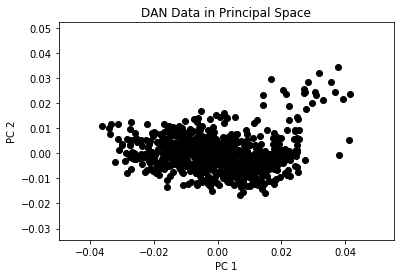

In [5]:
plt.scatter(X_t[:,0], X_t[:,1], color='black')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title("DAN Data in Principal Space")

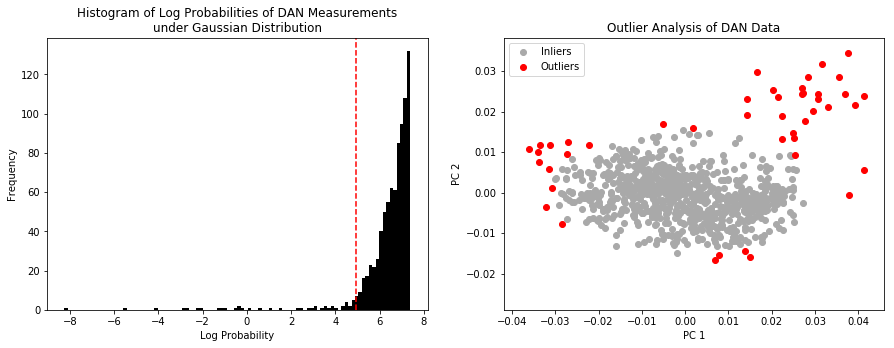

In [9]:
mu_1 = np.mean(X_t[:,0])
mu_2 = np.mean(X_t[:,1])
var_1 = np.std(X_t[:,0])**2
var_2 = np.std(X_t[:,1])**2

k = 1

p_1 = (1/(np.sqrt(2*np.pi)*np.sqrt(var_1))) * np.exp(-((X_t[:,0]-mu_1)**2)/(2*var_1))
p_2 = (1/(np.sqrt(2*np.pi)*np.sqrt(var_2))) * np.exp(-((X_t[:,1]-mu_2)**2)/(2*var_2))

scores = np.log(p_1 * p_2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.hist(scores, bins=100, color='k')
ax1.set_xlabel('Log Probability')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Log Probabilities of DAN Measurements\nunder Gaussian Distribution')
mu = np.mean(scores)
std = np.std(scores)
ax1.axvline(mu-k*std, color='r', linestyle='--')

inlier_ind = np.where(np.array(scores) > mu-k*std)
outlier_ind = np.where(np.array(scores) <= mu-k*std)
outliers = X_t[outlier_ind]
inliers = X_t[inlier_ind]

# Plot distributions in PC space
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_title("Outlier Analysis of DAN Data")
ax2.scatter(inliers[:,0], inliers[:,1], label='Inliers', color='darkgrey', picker=True)
ax2.scatter(outliers[:,0], outliers[:,1], label='Outliers', color='red', picker=True)
ax2.legend(loc='best')
plt.savefig('/Users/hannahrae/Documents/Grad School/DAN Manuscript/figures/novel_dan.pdf', transparent=True)

[[ 2.5867608e-17 -2.7101734e-17]]
2.929210335877916e-17
-2.6415200350327635e-17
(46, 2)


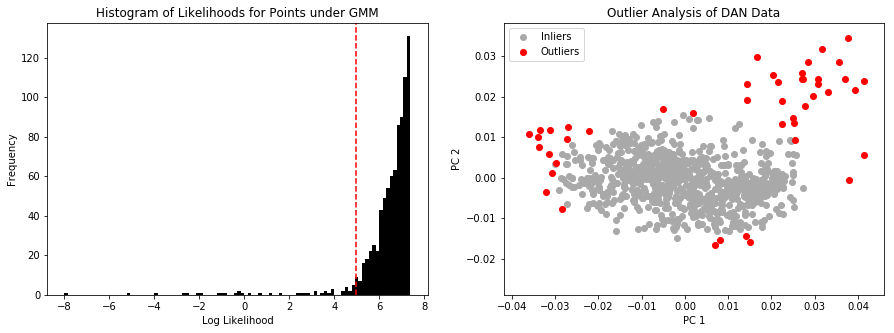

In [72]:
# # Determine outliers using Gaussian Mixture Model
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components=1, covariance_type='full').fit(X_t)

# scores = gmm.score_samples(X_t)
# mu = np.mean(scores)
# std = np.std(scores)

# ax1.hist(scores, bins=100, color='k')
# ax1.axvline(mu - std, c='red', ls='--')
# ax1.set_xlabel('Log Likelihood')
# ax1.set_ylabel('Frequency')
# ax1.set_title('Histogram of Likelihoods for Points under GMM')

# outlier_ind = np.where(scores <= mu - std)
# inlier_ind = np.where(scores > mu - std)

# outliers = X_t[outlier_ind]
# inliers = X_t[inlier_ind]

# print outliers.shape

# # Plot distributions in PC space
# ax2.set_xlabel('PC 1')
# ax2.set_ylabel('PC 2')
# ax2.set_title("Outlier Analysis of DAN Data")
# ax2.scatter(inliers[:,0], inliers[:,1], label='Inliers', color='darkgrey', picker=True)
# ax2.scatter(outliers[:,0], outliers[:,1], label='Outliers', color='red', picker=True)
# ax2.legend(loc='best')

# plt.savefig('/Users/hannahrae/Documents/Grad School/DAN Manuscript/figures/novel_dan.pdf', transparent=True)

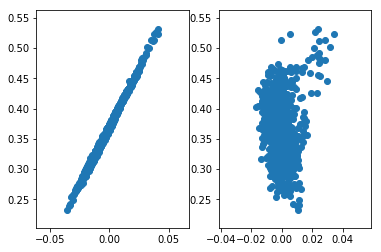

In [10]:
# Compute the total counts for each measurement
total_counts = np.sum(X, axis=1)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.scatter(X_t[:,0], total_counts)
ax2.scatter(X_t[:,1], total_counts)

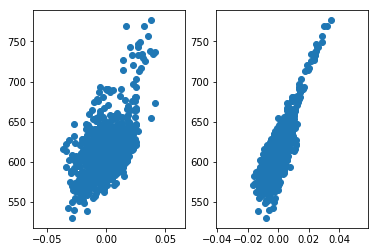

In [11]:
# Compute the flux-weighted time of arrival for each model measurement
def fwta(time_bins, counts):
    fwtas = np.ndarray(counts.shape[0])
    for i in range(counts.shape[0]):
        w_sum = 0
        #for t in range(10, counts.shape[1]):
        for t in range(counts.shape[1]):
            w_sum += time_bins[t] * counts[i,t]
        fwtas[i] = w_sum / float(np.sum(counts[i,:]))
    return fwtas

arr_time = np.array(fwta(np.take(datasets.time_bins_dan[:-1], range(17,34)), X))

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.scatter(X_t[:,0], arr_time)
ax2.scatter(X_t[:,1], arr_time)

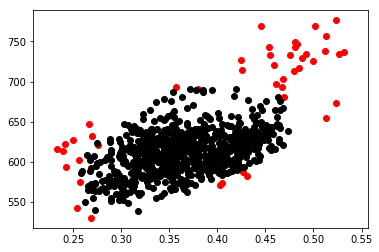

In [12]:
plt.scatter(total_counts[outlier_ind], arr_time[outlier_ind], color='r', label='Outliers')
plt.scatter(total_counts[inlier_ind], arr_time[inlier_ind], color='k', label='Inliers')

In [13]:
outlier_files = X_filenames[outlier_ind]
inlier_files = X_filenames[inlier_ind]
outlier_y = Y[outlier_ind]
inlier_y = Y[inlier_ind]

print len(outlier_files)
print zip(outlier_files, outlier_y)

45
[('DNA_407358722EAC01110050432_______M2', array([3.6  , 0.016])), ('DNA_407978705EAC01180050432_______M2', array([4.3   , 0.0169])), ('DNB_424384645EAC03030060450_______M3', array([4.6   , 0.0186])), ('DNB_424748259EAC03070060560_______M1', array([3.5   , 0.0177])), ('DNB_427412927EAC03370080318_______M1', array([3.9   , 0.0084])), ('DNB_430438852EAC03710130974_______M1', array([3.8   , 0.0101])), ('DNB_431504673EAC03830141364_______M1', array([2.3   , 0.0057])), ('DNB_431684307EAC03850150998_______M1', array([2.6   , 0.0057])), ('DNB_431937562EAC03880151178_______M1', array([3.    , 0.0057])), ('DNB_431947014EAC03880151230_______M2', array([2.1   , 0.0075])), ('DNB_431933472EAC03880151064_______M1', array([2.6   , 0.0075])), ('DNB_433324054EAC04040161052_______M1', array([1.8   , 0.0071])), ('DNB_433816866EAC04090170676_______M1', array([2.3   , 0.0061])), ('DNB_447573140EAC05640290298_______M1', array([1.3   , 0.0169])), ('DNB_449787953EAC05890310000_______M2', array([2.    , 0.02

[2.2    0.0118]
[2.6    0.0057]
DNB_448010653EAC05690291606_______M1
DNB_489554385EAC10370481942_______M1


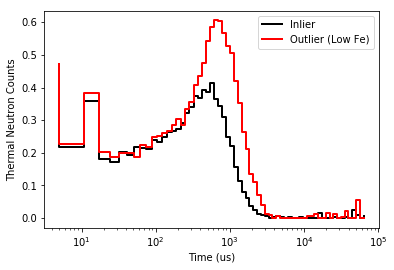

In [14]:
# Visualize an inlier and an outlier example
X_full, _, _, _ = datasets.read_dan_data()
X_full = np.take(X_full, range(64), axis=1)

print inlier_y[300]
print outlier_y[30]
print inlier_files[300]
print outlier_files[30]

outlier_x = X_full[outlier_ind]
inlier_x = X_full[inlier_ind]
plt.step(datasets.time_bins_dan[:-1], inlier_x[300], where='post', linewidth=2, label='Inlier', color='k')
plt.step(datasets.time_bins_dan[:-1], outlier_x[30], where='post', linewidth=2, label='Outlier (Low Fe)', color='r')
plt.xlabel('Time (us)')
plt.ylabel('Thermal Neutron Counts')
plt.xscale('log')
plt.legend()
plt.savefig('/Users/hannahrae/Documents/Jobs/Maryland/figs/dan_outlier.png')

2.2
0.0071


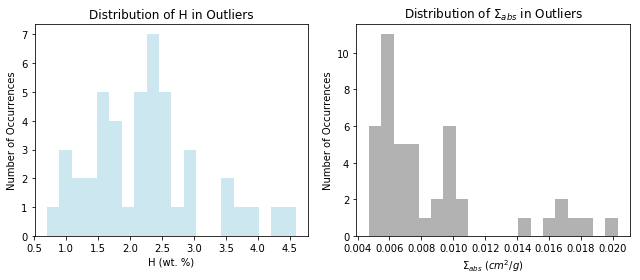

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))
ax[0].hist(outlier_y[:,0], bins=20, alpha=0.6, label='H', color='lightblue')
ax[1].hist(outlier_y[:,1], bins=20, alpha=0.6, label='$\Sigma_{abs}$', color='grey')
# Add graph labels
#plt.legend(loc='best')
ax[0].set_xlabel('H (wt. %)')
ax[1].set_xlabel('$\Sigma_{abs}$ ($cm^2/g$)')
ax[0].set_ylabel('Number of Occurrences')
ax[1].set_ylabel('Number of Occurrences')
ax[0].set_title('Distribution of H in Outliers')
ax[1].set_title('Distribution of $\Sigma_{abs}$ in Outliers')
#plt.xlim(0, 6)
plt.tight_layout()

print np.median(outlier_y[:,0])
print np.median(outlier_y[:,1])
plt.savefig('/Users/hannahrae/Desktop/outlier_geochemistry.pdf', transparent=True)

2.6
0.0118


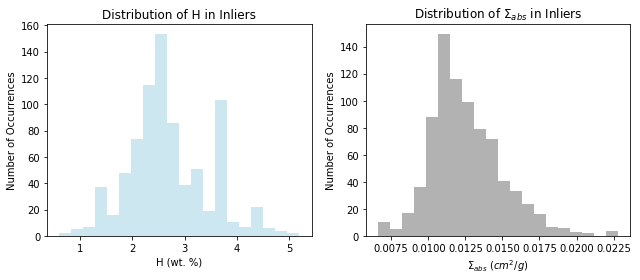

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))
ax[0].hist(inlier_y[:,0], bins=20, alpha=0.6, label='H', color='lightblue')
ax[1].hist(inlier_y[:,1], bins=20, alpha=0.6, label='$\Sigma_{abs}$', color='grey')
# Add graph labels
#plt.legend(loc='best')
ax[0].set_xlabel('H (wt. %)')
ax[1].set_xlabel('$\Sigma_{abs}$ ($cm^2/g$)')
ax[0].set_ylabel('Number of Occurrences')
ax[1].set_ylabel('Number of Occurrences')
ax[0].set_title('Distribution of H in Inliers')
ax[1].set_title('Distribution of $\Sigma_{abs}$ in Inliers')
#plt.xlim(0, 6)
plt.tight_layout()

print np.median(inlier_y[:,0])
print np.median(inlier_y[:,1])

plt.savefig('/Users/hannahrae/Desktop/inlier_geochemistry.pdf', transparent=True)

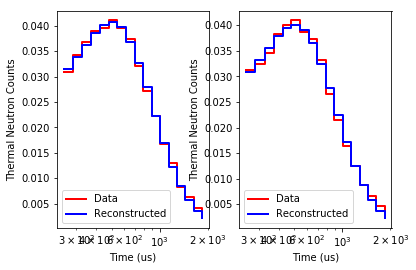

In [15]:
outlier_x_t = X_t[outlier_ind]
outlier_x = X[outlier_ind]
fig, axes = plt.subplots(ncols=2)
bins = np.take(datasets.time_bins_dan[:-1], range(17, 34), axis=0)
for i in range(2):
    axes[i].step(bins, outlier_x[i], where='post', linewidth=2, label='Data', color='r')
    recon = pca.inverse_transform(outlier_x_t[i])
    axes[i].step(bins, recon, where='post', linewidth=2, label='Reconstructed', color='b')
    axes[i].set_xlabel('Time (us)')
    axes[i].set_ylabel('Thermal Neutron Counts')
    axes[i].set_xscale('log')
    axes[i].legend()

[111, 118, 303, 307, 337, 371, 383, 385, 388, 388, 388, 404, 409, 564, 589, 690, 695, 706, 708, 713, 714, 744, 940, 981, 991, 992, 1028, 1035, 1035, 1035, 1037, 1037, 1042, 1049, 1051, 1056, 1243, 1305, 1659, 1659, 1719, 1748, 1796, 1798, 1802]


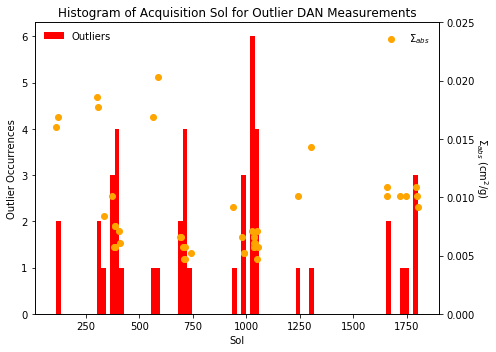

In [44]:
fig, ax1 = plt.subplots(figsize=(7,5))
outlier_sols = [int(fname.split('EAC')[-1][:4]) for fname in outlier_files]
print outlier_sols
plt.hist(outlier_sols, bins=80, label='Outliers', color='red')
# Add graph labels
ax1.legend(loc='upper left', frameon=False)
ax1.set_xlabel('Sol')
ax1.set_ylabel('Outlier Occurrences')
plt.title('Histogram of Acquisition Sol for Outlier DAN Measurements')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.get_yaxis().labelpad = 15
ax2.set_ylabel('$\Sigma_{abs}$ (cm$^2$/g)', rotation=270)
ax2.scatter(outlier_sols, outlier_y[:,1], color='orange', label='$\Sigma_{abs}$')
ax2.legend(loc='upper right', frameon=False)
ax2.set_ylim(0, 0.025)

# ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax3.get_yaxis().labelpad = 30
# ax3.set_ylabel('WEH (wt %)', rotation=270)
# ax3.scatter(outlier_sols, outlier_y[:,0], color='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('/Users/hannahrae/Documents/Grad School/DAN Manuscript/figures/outlier_sols.pdf', transparent=True)

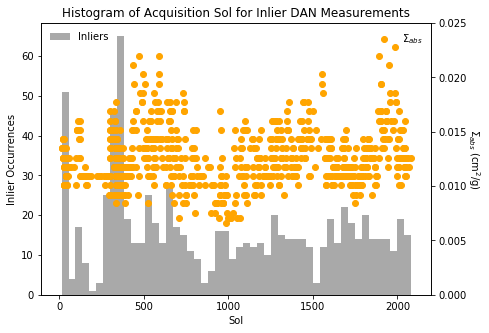

In [45]:
fig, ax1 = plt.subplots(figsize=(7,5))

inlier_sols = [int(fname.split('EAC')[-1][:4]) for fname in inlier_files]
ax1.hist(inlier_sols, bins=50, label='Inliers', color='darkgrey')
ax1.legend(loc='upper left', frameon=False)
ax1.set_xlabel('Sol')
ax1.set_ylabel('Inlier Occurrences')
ax1.set_title('Histogram of Acquisition Sol for Inlier DAN Measurements')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.get_yaxis().labelpad = 15
ax2.set_ylabel('$\Sigma_{abs}$ (cm$^2$/g)', rotation=270)
ax2.scatter(inlier_sols, inlier_y[:,1], color='orange', label='$\Sigma_{abs}$')
ax2.legend(loc='upper right', frameon=False)
ax2.set_ylim(0, 0.025)

plt.savefig('/Users/hannahrae/Documents/Grad School/DAN Manuscript/figures/inlier_sols.pdf', transparent=True)

['DNB_515477884EAC13290540938_______M1'
 'DNB_515473511EAC13290540812_______M1']


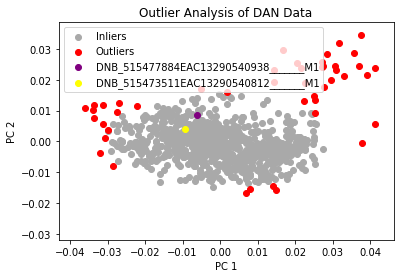

In [24]:
# Check where certain sols plot
lubango_inds = np.where(np.array(inlier_sols)==1329)
lubango = inliers[lubango_inds]
print inlier_files[lubango_inds]

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title("Outlier Analysis of DAN Data")
plt.scatter(inliers[:,0], inliers[:,1], label='Inliers', color='darkgrey', picker=True)
plt.scatter(outliers[:,0], outliers[:,1], label='Outliers', color='red', picker=True)
plt.scatter(lubango[0,0], lubango[0,1], label='DNB_515477884EAC13290540938_______M1', color='purple', picker=True)
plt.scatter(lubango[1,0], lubango[1,1], label='DNB_515473511EAC13290540812_______M1', color='yellow', picker=True)

plt.legend(loc='best')

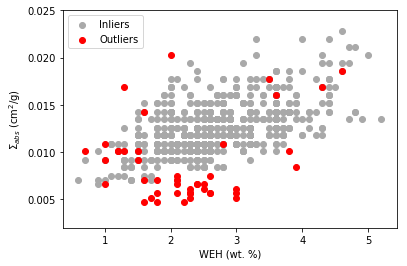

In [43]:
plt.scatter(inlier_y[:,0], inlier_y[:,1], label='Inliers', color='darkgrey')
plt.scatter(outlier_y[:,0], outlier_y[:,1], label='Outliers', color='red')

plt.ylim(0.002, 0.025)
# lubango_y = inlier_y[lubango_inds]
# print lubango_y[0]
# plt.scatter(lubango_y[0,0], lubango_y[0,1], label='DNB_515477884EAC13290540938_______M1', color='purple', picker=True)
# plt.scatter(lubango_y[1,0], lubango_y[1,1], label='DNB_515473511EAC13290540812_______M1', color='yellow', picker=True)

plt.xlabel("WEH (wt. %)")
plt.ylabel("$\Sigma_{abs}$ (cm$^2$/g)")
plt.legend(loc='best')

plt.savefig('/Users/hannahrae/Documents/Grad School/DAN Manuscript/figures/novel_geochem.pdf', transparent=True)

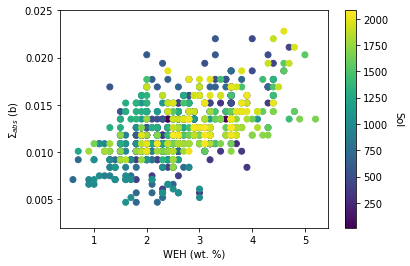

In [39]:
all_sols = [int(fname.split('EAC')[-1][:4]) for fname in X_filenames]
fig, ax = plt.subplots(1)
p = ax.scatter(Y[:,0], Y[:,1], c=all_sols)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Sol", rotation=270)
plt.ylim(0.002, 0.025)
plt.xlabel("WEH (wt. %)")
plt.ylabel("$\Sigma_{abs}$ (b)")
plt.legend(loc='best')

In [26]:
# Load the elevations from the localization spreadsheet
import csv
elev_dict = {}
with open('/Users/hannahrae/data/dan/dan_places.csv') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        if row[2] == '170': # ApID for DAN Active
            name = row[-4].split('/')[-1][:-4]
            elev = float(row[17])
            elev_dict[name] = elev

inlier_elevs = [elev_dict[fname] for fname in inlier_files]
outlier_elevs = [elev_dict[fname] for fname in outlier_files]

[(-4501.48, 21), (-4501.48, 22), (-4502.6, 25), (-4503.03, 26), (-4503.03, 27), (-4503.03, 29), (-4504.63332755203, 39), (-4509.36552625022, 48), (-4516.6, 52), (-4516.55, 54), (-4518.3, 103), (-4518.3, 104), (-4518.3, 105), (-4518.23, 111), (-4518.23, 112), (-4518.23, 118), (-4519.78, 123), (-4520.68, 153), (-4519.75632605159, 301), (-4519.24, 302), (-4518.81, 303), (-4519.21, 307), (-4518.23, 309), (-4518.06, 317), (-4517.71926441628, 327), (-4513.86, 331), (-4512.45167227866, 335), (-4510.86080311368, 336), (-4508.48698301452, 337), (-4502.14212312832, 342), (-4500.32876066216, 356), (-4501.23668228842, 361), (-4503.42983081819, 369), (-4503.29, 371), (-4502.43, 377), (-4502.53, 379), (-4503.41784894534, 383), (-4500.9, 385), (-4501.42305140882, 388), (-4501.67, 388), (-4500.87256857209, 388), (-4504.56985791051, 390), (-4504.85, 404), (-4503.23, 409), (-4494.31, 439), (-4491.0, 470), (-4488.78869710754, 494), (-4489.15, 508), (-4487.36, 526), (-4491.04, 547), (-4480.36, 563), (-448

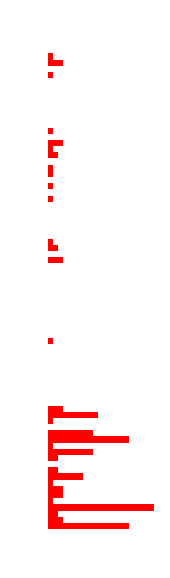

In [27]:
fig, ax = plt.subplots(1, figsize=(2,10))
ax.hist(outlier_elevs, bins=80, label='Outliers', color='red', orientation='horizontal', range=[-4520, -4130])
print zip(outlier_elevs, outlier_sols)
# Add graph labels
# plt.legend(loc='best')
# plt.xlabel('Global Elevation (m)')
# plt.gca().axes.get_yaxis().set_visible(False)
# plt.xlabel('Number of Measurements')

# plt.title('Distribution of Elevation in Outliers')
ax.axis('off')
plt.savefig('/Users/hannahrae/Documents/Grad School/DAN Manuscript/figures/elevation_hist.pdf', transparent=True)

In [ ]:
y = range(-4520, -4130, 10)
print y

In [ ]:
plt.hist(inlier_elevs, bins=80, label='Inliers', color='darkgrey')
plt.legend(loc='best')
plt.xlabel('Global Elevation (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Elevation in Inliers')

Nothing before sol 52 has an RHAZ
52 could be interesting (cracked clay area?)
No RHAZ for 54
103/104/111/118 looks like something / bedrock / some large float rock?
123 similar to above?
153 looks like some bedrock - there was a DRT on 150, maybe same thing?
we had a meteorite on 346
714 Mastcam had some interesting broken rocks
705 we looked at a dump pile
939 we had a weird DRT and a dump pile
990 we had some weird broken rocks
same for 999
1246 we had a drt that was hardly visible
1314 more interesting broken rocks

should cross reference these with Danika's selections

Text(0.5,1,u'Distribution of Geochemistry in Novel Measurements')

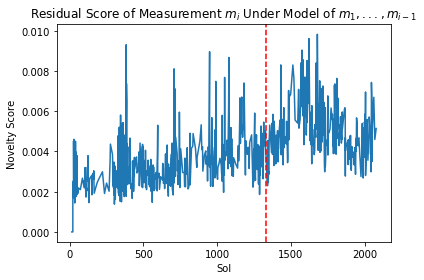

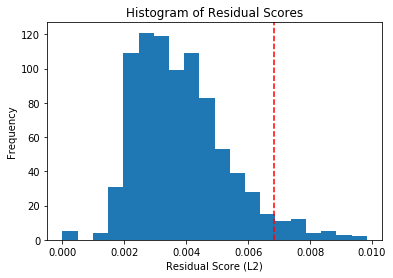

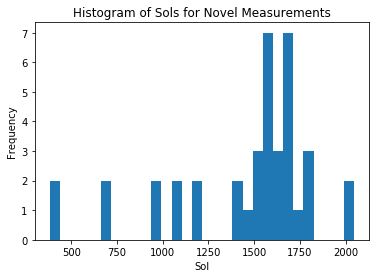

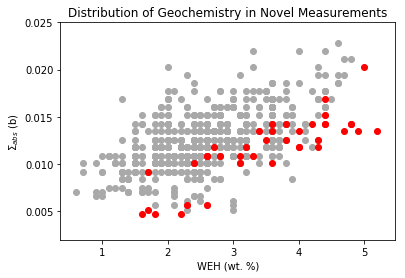

In [41]:
pca = PCA(n_components=2)
scores = []

for i in range(X.shape[0]):
    if i in range(5):
        scores.append(0)
        continue
    # Build a model using measurements up to this point
    pca.fit(X[:i,:])
    x_recon = pca.inverse_transform([pca.transform([X[i]])])[0][0]
    score = np.linalg.norm(X[i,:]-x_recon, ord=2)
    scores.append(score)

sols = [int(fname.split('EAC')[-1][:4]) for fname in X_filenames]
fig, ax = plt.subplots(1)
ax.plot(sols, scores)
ax.axvline(1329, linestyle='--', color='red')
ax.set_xlabel("Sol")
ax.set_ylabel("Novelty Score")
ax.set_title("Residual Score of Measurement $m_i$ Under Model of $m_1, ..., m_{i-1}$")

mu = np.mean(scores)
std = np.std(scores)
threshold = mu + 2*std

fig, ax = plt.subplots(1)
ax.hist(scores, bins=20)
ax.axvline(threshold, color='red', linestyle='--')
ax.set_ylabel("Frequency")
ax.set_xlabel("Residual Score (L2)")
ax.set_title("Histogram of Residual Scores")

fig, ax = plt.subplots(1)
novel_inds = np.where(np.array(scores)>=threshold)
typical_inds = np.where(np.array(scores)<threshold)

novel_filenames = X_filenames[novel_inds]
novel_sols = [int(fname.split('EAC')[-1][:4]) for fname in novel_filenames]
novel_y = Y[novel_inds]
typical_y = Y[typical_inds]
ax.hist(novel_sols, bins=30)
ax.set_xlabel("Sol")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Sols for Novel Measurements")

fig, ax = plt.subplots(1)
ax.scatter(typical_y[:,0], typical_y[:,1], color='darkgrey')
ax.scatter(novel_y[:,0], novel_y[:,1], color='red')
plt.ylim(0.002, 0.025)
# plt.hist(novel_y[:,0], bins=20, alpha=0.6, label='H', color='lightblue')
# plt.hist(novel_y[:,1], bins=20, alpha=0.6, label='$\Sigma_{abs}$', color='grey')
# Add graph labels
plt.legend(loc='best')
plt.xlabel("WEH (wt. %)")
plt.ylabel("$\Sigma_{abs}$ (b)")
plt.title('Distribution of Geochemistry in Novel Measurements')

[[3.5   0.929]
 [2.3   0.93 ]
 [2.6   0.93 ]
 [2.6   0.93 ]
 [3.8   0.977]
 [2.6   0.734]
 [2.3   0.734]
 [2.8   1.171]
 [3.9   0.634]
 [1.9   0.734]
 [1.5   0.734]
 [3.8   0.733]
 [2.3   0.398]
 [2.6   0.398]
 [3.    0.398]
 [2.6   0.585]
 [1.8   0.536]
 [2.3   0.444]
 [1.5   0.979]
 [1.3   1.124]
 [2.    0.979]
 [2.    1.315]
 [2.3   1.267]
 [2.3   1.219]
 [2.1   1.172]
 [1.5   0.93 ]
 [2.2   1.124]
 [1.4   0.734]
 [1.1   0.784]
 [2.5   0.49 ]
 [2.1   0.49 ]
 [1.8   0.398]
 [2.2   0.306]
 [1.3   0.833]
 [0.7   0.685]
 [0.6   0.536]
 [2.1   0.398]
 [1.8   0.306]
 [2.3   0.352]
 [1.6   0.635]
 [1.3   0.586]
 [1.    0.685]
 [0.9   0.536]
 [1.6   0.833]
 [0.9   0.685]
 [1.    0.49 ]
 [1.3   0.685]
 [0.9   0.49 ]
 [1.3   0.685]
 [1.7   0.352]
 [3.    0.352]
 [1.1   0.586]
 [2.4   0.49 ]
 [2.3   0.398]
 [2.4   0.49 ]
 [2.6   0.398]
 [2.6   0.444]
 [2.6   0.444]
 [1.    0.685]
 [1.6   0.306]
 [2.3   0.398]
 [0.7   0.735]
 [1.6   0.979]
 [1.6   0.979]
 [1.3   0.882]
 [1.8   0.93 ]
 [0.8   0.

Text(0.5,1,u'Distribution of Geochemistry in Novel Measurements')

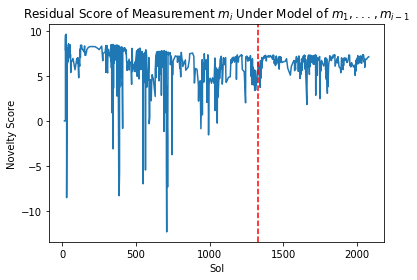

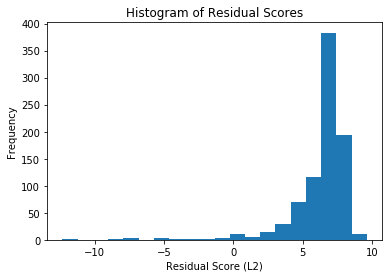

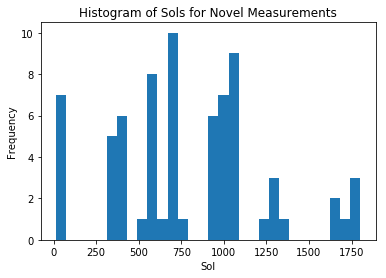

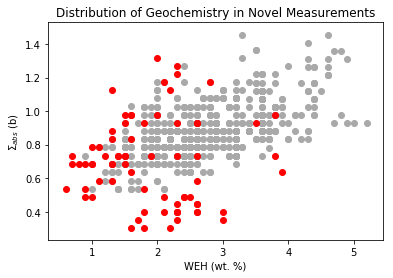

In [53]:
pca = PCA(n_components=2)
scores = []

for i in range(X.shape[0]):
    if i in range(5):
        scores.append(0)
        continue
    # Build a model using measurements up to this point
    pca.fit(X[:i,:])
    gmm = GaussianMixture(n_components=1, covariance_type='full').fit(pca.transform(X[:i,:]))
    score = gmm.score_samples(pca.transform([X[i,:]]))
    scores.append(score)

sols = [int(fname.split('EAC')[-1][:4]) for fname in X_filenames]
fig, ax = plt.subplots(1)
ax.plot(sols, scores)
ax.axvline(1329, linestyle='--', color='red')
ax.set_xlabel("Sol")
ax.set_ylabel("Novelty Score")
ax.set_title("Residual Score of Measurement $m_i$ Under Model of $m_1, ..., m_{i-1}$")

fig, ax = plt.subplots(1)
ax.hist(scores, bins=20)
ax.set_ylabel("Frequency")
ax.set_xlabel("Residual Score (L2)")
ax.set_title("Histogram of Residual Scores")

fig, ax = plt.subplots(1)
novel_inds = np.where(np.array(scores)<=4)
typical_inds = np.where(np.array(scores)>4)

novel_filenames = X_filenames[novel_inds]
novel_sols = [int(fname.split('EAC')[-1][:4]) for fname in novel_filenames]
novel_y = Y[novel_inds]
typical_y = Y[typical_inds]
ax.hist(novel_sols, bins=30)
ax.set_xlabel("Sol")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Sols for Novel Measurements")

print novel_y
fig, ax = plt.subplots(1)
ax.scatter(typical_y[:,0], typical_y[:,1], color='darkgrey')
ax.scatter(novel_y[:,0], novel_y[:,1], color='red')

# plt.hist(novel_y[:,0], bins=20, alpha=0.6, label='H', color='lightblue')
# plt.hist(novel_y[:,1], bins=20, alpha=0.6, label='$\Sigma_{abs}$', color='grey')
# Add graph labels
plt.legend(loc='best')
plt.xlabel("WEH (wt. %)")
plt.ylabel("$\Sigma_{abs}$ (b)")
plt.title('Distribution of Geochemistry in Novel Measurements')

In [ ]:
# Gather all the data
all_sols = np.concatenate([inlier_sols, outlier_sols])
all_elevs = np.concatenate([inlier_elevs, outlier_elevs])
all_x = np.concatenate([X[inlier_ind], X[outlier_ind]])
all_y = np.concatenate([Y[inlier_ind], Y[outlier_ind]])
all_chi2 = np.concatenate([chi2[inlier_ind], chi2[outlier_ind]])

# np.savetxt('/Users/hannahrae/data/dan/dan_sol-weh-bnacs-chi2_hiweh_sol1-2319.csv', zip(all_sols, all_y[:,0], all_y[:,1], all_chi2), fmt='%s', delimiter=',')
np.savetxt('/Users/hannahrae/data/dan/dan_sol-weh-bnacs-unc-chi2-elev_hiweh_sol1-2100.csv', zip(all_sols, all_y[:,0], all_y[:,1], all_chi2, all_elevs), fmt='%s', delimiter=',')